# Remap vertical coordinate in CAM from hybrid levels to geopotential height

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
from glob import glob

import dask
import metpy.calc as mcalc

import matplotlib.pyplot as plt

In [29]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join('/glade/scratch',os.environ['USER'],
                                            'dask/scheduler.json'))
client

Client Scheduler: tcp://10.148.9.117:8786 Dashboard: http://10.148.9.117:8787,Cluster Workers: 44 Cores: 176 Memory: 528.00 GB


### load CESM dataset

In [5]:
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'
component = 'atm'
stream = 'cam.h0'
datestr = '20070101-20160229'

file_patt = os.path.join('/glade/p/eol/stephens/longcoll/hpss-mirror',case,component,'proc/tseries/daily',
                         '.'.join([case,stream,'{}',datestr,'nc']))
varlist = ['Z3','CO2']

ds = {}
for v in varlist:
    #f = glob(file_patt.format(v))[0]
    f = '/glade/scratch/mclong/tmp/{}.nc'.format(v)
    print f
    ds = xr.merge((ds,xr.open_dataset(f,drop_variables=['time_written','date_written',
                                                        'date','datesec','mdt','nbsec','nsbase',
                                                        'nsteph','ntrk','ntrm','ntrn'])))
print('ds size: {:0.2f}GB\n'.format(ds.nbytes / 1e9))
ds.info()

/glade/scratch/mclong/tmp/Z3.nc
/glade/scratch/mclong/tmp/CO2.nc
ds size: 2.50GB

xarray.Dataset {
dimensions:
	ilev = 57 ;
	lat = 192 ;
	lev = 56 ;
	lon = 288 ;
	nbnd = 2 ;
	slat = 191 ;
	slon = 288 ;
	time = 101 ;

variables:
	float64 P0() ;
		P0:long_name = reference pressure ;
		P0:units = Pa ;
	float32 Z3(time, lev, lat, lon) ;
		Z3:mdims = 1 ;
		Z3:units = m ;
		Z3:long_name = Geopotential Height (above sea level) ;
		Z3:cell_methods = time: mean ;
	float64 ch4vmr(time) ;
		ch4vmr:long_name = ch4 volume mixing ratio ;
	float64 co2vmr(time) ;
		co2vmr:long_name = co2 volume mixing ratio ;
	float64 f11vmr(time) ;
		f11vmr:long_name = f11 volume mixing ratio ;
	float64 f12vmr(time) ;
		f12vmr:long_name = f12 volume mixing ratio ;
	float64 gw(lat) ;
		gw:long_name = gauss weights ;
	float64 hyai(ilev) ;
		hyai:long_name = hybrid A coefficient at layer interfaces ;
	float64 hyam(lev) ;
		hyam:long_name = hybrid A coefficient at layer midpoints ;
	float64 hybi(ilev) ;
		hybi:long_name 

### specify chunking

See here: http://xarray.pydata.org/en/stable/dask.html

What is the size of a chunk?

In [6]:
chunk = {'time':100,'lat':24.,'lon':36.,'lev':56}
nelements = np.prod(np.array([v for v in chunk.values()])).astype(int)
nbytes = nelements * 8
print('N elements per chunk {:d}\nChunk size in GB {:0.2f}\n'.format(nelements,nbytes / 1e9))

N elements per chunk 4838400
Chunk size in GB 0.04



Apply chunking 

In [7]:
ds = ds.chunk(chunk)
ds.chunks

Frozen(SortedKeysDict({u'nbnd': (2,), u'slat': (191,), u'lon': (36, 36, 36, 36, 36, 36, 36, 36), u'ilev': (57,), u'lev': (56,), u'time': (100, 1), u'lat': (24, 24, 24, 24, 24, 24, 24, 24)}))

### compute a new vertical coordinate based on the mean geopotential height field over the ocean

In [8]:
landfrac = xr.open_dataset('/glade/p/work/mclong/grids/f09_f09.nc')['LANDFRAC'].isel(time=0)
landfrac

<xarray.DataArray 'LANDFRAC' (lat: 192, lon: 288)>
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
    time     datetime64[ns] 2007-11-01
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by land
    cell_methods:  time: mean

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 248 ms


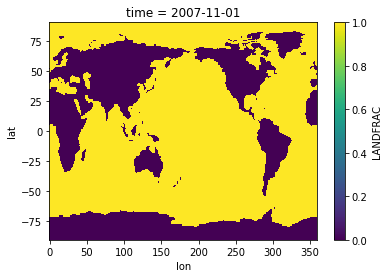

In [9]:
%%time
rmask = landfrac.where(landfrac<0.9).fillna(0.).where(landfrac>=0.9).fillna(1.)
rmask.plot()

In [20]:
%%time
z3 = ds.Z3.where(rmask==1).mean(dim=['time','lon','lat'])
z3 = z3.rename({'lev':'zlev'})
print z3

<xarray.DataArray (zlev: 56)>
dask.array<shape=(56,), dtype=float32, chunksize=(56,)>
Coordinates:
  * zlev     (zlev) float64 1.868 2.353 2.948 3.677 4.562 5.632 6.918 8.456 ...
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 9.1 ms


Load into memory using [`persist`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.persist.html#xarray.Dataset.persist), which keeps as dask array.

In [21]:
%%time
z3 = z3.persist()


CPU times: user 32 ms, sys: 16 ms, total: 48 ms
Wall time: 39.4 ms


CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 40.9 ms


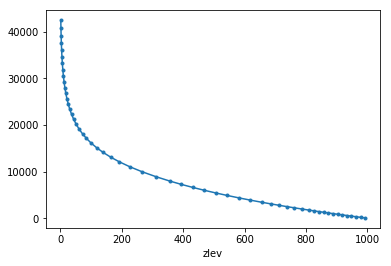

In [22]:
%%time
z3.plot(marker='.')

### compute coordinate transformation

Remap the coordinate itself to enable verification: this field should be close to uniform at each new vertical level, except where the value is out of bounds there should be missing values.

Some problems that arise: 

- KilledWorker exception: https://stackoverflow.com/questions/46691675/what-do-killedworker-exceptions-mean-in-dask

In [23]:
coord_field = ds.Z3
data_field = ds.Z3
print coord_field
print data_field

<xarray.DataArray 'Z3' (time: 101, lev: 56, lat: 192, lon: 288)>
dask.array<shape=(101, 56, 192, 288), dtype=float32, chunksize=(100, 56, 24, 36)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lev      (lev) float64 1.868 2.353 2.948 3.677 4.562 5.632 6.918 8.456 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 2007-01-03 ...
Attributes:
    mdims:         1
    units:         m
    long_name:     Geopotential Height (above sea level)
    cell_methods:  time: mean
<xarray.DataArray 'Z3' (time: 101, lev: 56, lat: 192, lon: 288)>
dask.array<shape=(101, 56, 192, 288), dtype=float32, chunksize=(100, 56, 24, 36)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lev      (lev) float64 1.868 2.353 2.948 3.677 4.562 5.632 6.918 8.456 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25

#### use the MetPy calc package to interpolate

I tried to work with [`apply_ufunc`](http://xarray.pydata.org/en/stable/generated/xarray.apply_ufunc.html#xarray.apply_ufunc), but it gives unexpected results.  

So I am trying [`dask.array`](http://dask.pydata.org/en/latest/array-api.html#create-and-store-arrays), and using the [`.data`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.data.html#xarray.DataArray.data) attribute of the xarray DataArrays.

In [24]:
%%time
data = xr.full_like(data_field,np.nan)
data.data = data.data.map_blocks(mcalc.log_interp,z3,coord_field,data_field,{'axis':1},dtype=float)
print data

<xarray.DataArray 'Z3' (time: 101, lev: 56, lat: 192, lon: 288)>
dask.array<shape=(101, 56, 192, 288), dtype=float64, chunksize=(100, 56, 24, 36)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lev      (lev) float64 1.868 2.353 2.948 3.677 4.562 5.632 6.918 8.456 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 2007-01-03 ...
Attributes:
    mdims:         1
    units:         m
    long_name:     Geopotential Height (above sea level)
    cell_methods:  time: mean
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 10.6 ms


#### replace lev vertical dimension/coordinate with new vertical coordinate

In [25]:
%%time
data = data.rename({'lev':'zlev'})
data['zlev'] = z3
print data

<xarray.DataArray 'Z3' (time: 101, zlev: 56, lat: 192, lon: 288)>
dask.array<shape=(101, 56, 192, 288), dtype=float64, chunksize=(100, 56, 24, 36)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * zlev     (zlev) float32 42428.5 40751.5 39134.7 37575.1 36067.8 34610.3 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 2007-01-03 ...
Attributes:
    mdims:         1
    units:         m
    long_name:     Geopotential Height (above sea level)
    cell_methods:  time: mean
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.4 ms


### try to make a plot

This fails...

In [26]:
%%time
data.isel(time=0,zlev=0).plot()

distributed.utils - ERROR - <this-array>
Traceback (most recent call last):
  File "/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/distributed/utils.py", line 238, in f
    result[0] = yield make_coro()
  File "/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/tornado/gen.py", line 1063, in run
    yielded = self.gen.throw(*exc_info)
  File "/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/distributed/client.py", line 1304, in _gather
    traceback)
  File "/glade/p/work/mclong/miniconda2/envs/py2/lib/python2.7/site-packages/xarray/core/dataarray.py", line 610, in _dask_finalize
    variable = ds._variables.pop(_THIS_ARRAY)
  File "pyt

KeyError: <this-array>